<a href="https://colab.research.google.com/github/leotuni/Nicolas-stuff/blob/master/SCTC_leo_no_note_26_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title imports
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np 
from itertools import product 


#display tools 
from IPython.display import display
pd.options.display.max_columns = None
# style.use('ggplot') #this is a cool style

#Plots
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import plotly.graph_objects as go


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
#@title Dataframe setup  { form-width: "30px" }
#the date in a nice date format
start_date_data = '2018-02-14' #@param {type:"date"} 
start = dt.datetime.strptime(start_date_data, '%Y-%m-%d') 
stop = dt.datetime.now()

#the symbols you gave me 
symbols = ['BTC-EUR','ETH-EUR', 'LTC-EUR' , 'XRP-EUR', 'BCH-EUR','MIOTA-EUR' ]


#create a dictionary with all the stocks Q: do you prefer to work with lists of dictionaries ? 
dict_of_stock = { s: web.DataReader(s, "yahoo", start, stop) for s in (symbols) }


In [4]:
#@title Functions SMA part (set BUY as + and Sell as - In dataframe)  { form-width: "30px" }

def conditions_fun (df, col1, col2, choices= '''[df['Close'], -df['Close']]''', defa = 0): 
    ''' 
      dataframe, col2, col2, choice after condition, defa = 0
      returns pandas series, index taken from df. 
      Choices decide if we assing a postive or a negative number when buy or sell condition is met
    
    '''
    conditions = [
                    ((df[col1] > df[col2]) & (df[col1].shift(1) < df[col2].shift(1))), #buy condition
                    ((df[col1] < df[col2]) & (df[col1].shift(1) > df[col2].shift(1))), #sell condition
                    ]
    return  (pd.Series(np.select(conditions, choices, default=defa), index=df.index)) #default value we do nothing



In [5]:
#@title SMA main: different rolling window sizes { form-width: "30px" }

#Only getting close since it is all we are using 
Close=dict_of_stock['BTC-EUR']['Close']
Close=Close.groupby(Close.index).first() #removes the duplicate indexes

# made them from 2-6 , 7-11 just cause it is easier to see. made into strings cause im using them as col_names
SMA1 = list(map(str, range(2, 30))) #
SMA2 = list(map(str, range(31, 60)))

# # table = [ Close.rolling(s,min_periods=1).mean() for s in (np.arange(1,10))]
data = pd.DataFrame.from_dict({ s: Close.rolling(int(s),min_periods=1).mean() for s in SMA1 + SMA2 }) 
data.insert(0, 'Close', Close)


#This creates a df for the buy and sell values based on the conditions
buy_sell_df = pd.DataFrame.from_dict({  sma1 + '_' + sma2: conditions_fun (data, sma1, sma2 , choices= [data['Close'], -data['Close']])  for sma1, sma2  in product(SMA1, SMA2) })
buy_sell_df.insert(0, 'Close', Close)

# other solution, currently not using it. 
# buy_sell_df.where(buy_sell_df.gt(0).cummax(), 0, inplace=True) #https://stackoverflow.com/questions/62533032/pandas-replace-col-values-before-first-postive-with-0/62533267#62533267
 

#if last non-zero element is negative(buying), replace with 0
s = buy_sell_df.iloc[::-1] #inverts the dataframe 
buy_sell_df[s.lt(0).cumsum().eq(1) & (~s.gt(0).cummax())] = 0

#if first non-zero elemnt is positive (selling), replace with 0
s= buy_sell_df.iloc[::] #normal dataframe 
buy_sell_df[s.gt(0).cumsum().eq(1) & (~s.lt(0).cummax())] = 0


# #look at these two 
# data
# pd.set_option('display.max_rows', None)

# buy_sell_df[:]



In [6]:
#26/07/2020:
#DQ-check if all trades are closed
buy_sell_df_drop_close = buy_sell_df.drop(['Close'], axis=1)
NumTradeStrat = buy_sell_df_drop_close.ne(0).cumsum().max()
TradeClosed = NumTradeStrat%2
sum(TradeClosed.eq(1).cumsum()) #should be zero

0

In [ ]:
#@title PLOT: Frequency of buy sell events for SMA pairs

mask_gt=buy_sell_df.gt(0)
mask_lt=buy_sell_df.lt(0)
Data=buy_sell_df.drop(['Close'], axis=1)
Data[mask_gt]=1
Data[mask_lt]=-1

fig = go.Figure(data=go.Heatmap(
        z=Data.to_numpy().transpose(),
        x=Data.index,
        y=Data.columns,
        colorscale='Viridis'))

fig.update_layout(
    title='Buy (B) sell(Y) shown over time',
    xaxis_nticks=36)

fig.show()

In [ ]:
#@title PLOT:  Heatmap #of times a buy/sell is triggered 
#since they area all odd this makes no sense. 

# Counts= buy_sell_df.astype(bool).sum(axis=0).drop('Close', inplace=True)
Counts = pd.DataFrame( { 'Position': buy_sell_df.astype(bool).sum(axis=0)[1:].index, 'Value': buy_sell_df.astype(bool).sum(axis=0)[1:]  } ) 
Counts.index=pd.MultiIndex.from_tuples(Counts.Position.str.split('_').apply(tuple))

c=Counts.Value.unstack(0)
#make the colums into integers
c.columns = pd.to_numeric(c.columns, errors = 'coerce')
c.sort_index(axis=1, inplace= True)

#make the index ordered 
c.index= pd.to_numeric(c.index, errors = 'coerce')
c.sort_index(axis=0, inplace=True)


ax = sns.heatmap(c)
plt.ylabel('SMA1')
plt.xlabel('SMA2')
plt.title('Heatmap #of conditions met')



In [ ]:
c

The best SMA: evaluations are - : 



Text(0.5, 1.0, 'Heatmap Profit (-buy + sell)')

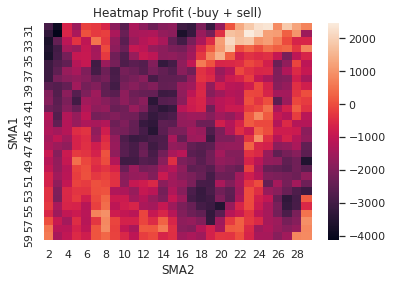

In [10]:
#@title PLOT Heatmap of profit for SMA: https://stackoverflow.com/questions/62640043/python-create-heatmap-using-string-in-col1-x-y-as-coordinates { form-width: "30px" }
Profit = pd.DataFrame( { 'Position': buy_sell_df.sum()[1:].index, 'Value': buy_sell_df.sum()[1:]  } ) 


Profit.index=pd.MultiIndex.from_tuples(Profit.Position.str.split('_').apply(tuple))
p=Profit.Value.unstack(0)

p.columns = pd.to_numeric(p.columns, errors = 'coerce')
p.sort_index(axis=1, inplace= True)
p.index= pd.to_numeric(p.index, errors = 'coerce')
p.sort_index(axis=0, inplace=True)


ax = sns.heatmap(p)
plt.ylabel('SMA1')
plt.xlabel('SMA2')
plt.title('Heatmap Profit (-buy + sell)')


# Profit.max()['Value']



#19-07 Nicolas Update

In [11]:
#@title Leo's version of "#19/07/2020: Find maximum values & position" and "#19/07/2020:" (the 2 cells above) { form-width: "30px" }

best_sma1, best_sma2 = list(map(int, Profit['Value'].idxmax(axis=1))) 

print("Maximum Return was ", Profit['Value'].max() )
print("best short SMA pair is: ",best_sma1, ' ', best_sma2)



Maximum Return was  2472.257568359375
best short SMA pair is:  23   32


In [12]:
Profit.sort_values(by='Value', ascending=False).head()

Position        Value
23 32    23_32  2472.257568
25 31    25_31  2345.055176
24 31    24_31  2285.109619
   32    24_32  2167.719238
21 33    21_33  2154.839600

In [ ]:
#26/07/2020: Getting Trades
Trades = buy_sell_df['23_32'][buy_sell_df['23_32'].ne(0)]
Trades





In [47]:
#Trades
#for idx, val enumerate(Trades):
#    print(idx)
def Get_Returns(Trades):
    AbsReturn = []
    PrcntReturn = []
    for i in range(1, len((Trades)), 2):
        print (i, i-1)
        Abs = Trades[i] + Trades[i-1]
        print (Abs)
        AbsReturn.append(Abs)
        Prcnt = ((Trades[i] + Trades[i-1])/(Trades[i-1]*-1))
        PrcntReturn.append(Prcnt)
    AbsReturn.sort(), PrcntReturn.sort()
    
    return AbsReturn, PrcntReturn


In [ ]:
AbsReturn, PrcntReturn =  Get_Returns(Trades)

AbsReturn, PrcntReturn 


In [ ]:
np.mean(AbsReturn), np.mean(PrcntReturn)



# My attempt at what you did above 26/07


In [ ]:
#@title Making a dataframe with ABSreturn, PCRreturn and other values
def Returns_frame (df_ =buy_sell_df, pair='23_32'):
  s = df_[pair] #s for series just to cut back on writing buy_sell_df[pair] on every line. 
  df_= pd.DataFrame({
      'Buy_date'   : s.index[s < 0],
      'Sell_date'  : s.index[s > 0],
      'AbsReturn'  : s[s>0] + s[s<0].to_numpy(),    
      'PrcntReturn': (s[s>0] + s[s<0].to_numpy())/ (s[s<0].to_numpy()*-1),                 
                     })
  df_['Open_time'] = df_['Sell_date']-df_['Buy_date']
  df_['AbsReturn_perday'] = df_['AbsReturn']/df_['Open_time'].dt.days
  df_["C"] = np.sign(df_['AbsReturn'])
  return(df_)
  

Returns_frame()


From the graph below you can tell that when we are losing money we have long open positions, and they tend to lose a lot of money. 

In [113]:
df_=Returns_frame()
df_['Open_time']=df_['Open_time'].dt.days
fig = px.scatter_matrix(df_,
    dimensions=["Open_time", "PrcntReturn", "AbsReturn_perday", "AbsReturn"],
    color="C")
fig.show()

In [112]:
df_=Returns_frame()

fig = go.Figure()
fig.add_trace(
        go.Scatter(x=df_["AbsReturn"], y=df_["Open_time"].dt.days,  mode='markers',
                #    hovertext=df_['iteration'] ,
                #    hovertemplate =
                #    '<b>Vth_sat<b>: %{y:.2f} [V]'   +
                #    '<br><b>time</b>: %{x: .1f} [s]<br>'+
                #    '<b>Iter<b>: %{hovertext}'),
                #  secondary_y=False 
                ))


(array([1., 0., 0., 1., 1., 1., 4., 3., 3., 2.]),
 array([-0.31323898, -0.26332867, -0.21341836, -0.16350804, -0.11359773,
        -0.06368742, -0.01377711,  0.03613321,  0.08604352,  0.13595383,
         0.18586414]),
 <a list of 10 Patch objects>)

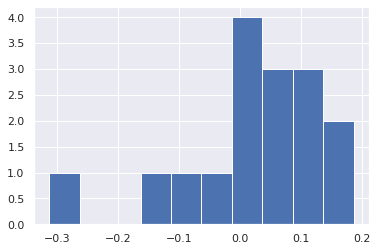

In [49]:
plt.hist(PrcntReturn)

(array([1., 1., 0., 1., 1., 3., 3., 2., 2., 2.]),
 array([-1588.83666992, -1305.73601074, -1022.63535156,  -739.53469238,
         -456.4340332 ,  -173.33337402,   109.76728516,   392.86794434,
          675.96860352,   959.0692627 ,  1242.16992188]),
 <a list of 10 Patch objects>)

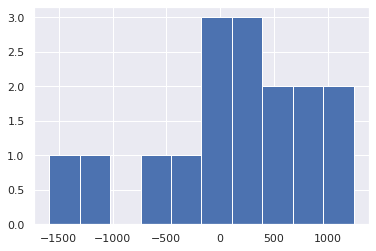

In [50]:
plt.hist(AbsReturn)

In [ ]:
# just ignor maybe later
# Overview on trades
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib import style
pd.core.common.is_list_like = pd.api.types.is_list_like
import scipy
from scipy.stats import norm
#get all trades
# rank from low to high

mean = np.mean(AbsReturn)
std_dev = np.std(AbsReturn)
AbsReturn.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5)
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
plt.plot(x,scipy.stats.norm.pdf(x, mean, std_dev), "r" )
plt.show()

#VaR Computation 
VaR_90 = norm.ppf(1-0.9, mean, std_dev)
VaR_95 = norm.ppf(1-0.95, mean, std_dev)
VaR_99 = norm.ppf(1-0.99, mean, std_dev)

print('VaR 90% Confidence Level:   ', VaR_90)
print('VaR 95% Confidence Level:   ', VaR_95)
print('VaR 99% Confidence Level:   ', VaR_99)

In [ ]:
#19/07/2020:
# Plot Graph
Close_graph = pd.DataFrame(Close)#, columns='Close') 
Close_graph['SMA1'] = Close_graph['Close'].rolling(best_sma1,min_periods=1).mean() 
Close_graph['SMA2'] = Close_graph['Close'].rolling(best_sma2,min_periods=1).mean() 
Close_graph['Position'] = np.where(Close_graph['SMA1']> Close_graph['SMA2'],1,-1)
Close_graph.head()# plot(figsize = (25,12))


In [ ]:
Close_graph[['Close','SMA1','SMA2','Position']].plot(figsize = (25,12),secondary_y = 'Position')

# Consistency Check

In [ ]:
#26/07/2020 # from what i could see on https://de.finance.yahoo.com/quote/BTC-EUR?p=BTC-EUR, september 2014 is the starting date of bit coin
 

#@title Dataframe setup  { form-width: "30px" }
#the date in a nice date format
start_date_data1 = '2014-10-01' #@param {type:"date"}  
start1 = dt.datetime.strptime(start_date_data1, '%Y-%m-%d') 
stop1 = dt.datetime.now()

#the symbols you gave me 
symbols = ['BTC-EUR','ETH-EUR', 'LTC-EUR' , 'XRP-EUR', 'BCH-EUR','MIOTA-EUR' ]

#create a dictionary with all the stocks Q: do you prefer to work with lists of dictionaries ? 
dict_of_stock1 = { s: web.DataReader(s, "yahoo", start1, stop1) for s in (symbols) }

In [ ]:
#@title SMA main: different rolling window sizes { form-width: "30px" }

#Only getting close since it is all we are using 
Close1=dict_of_stock1['BTC-EUR']['Close']
Close1=Close1.groupby(Close1.index).first() #removes the duplicate indexes

# made them from 2-6 , 7-11 just cause it is easier to see. made into strings cause im using them as col_names
SMA1 = list(map(str, range(2, 30))) #
SMA2 = list(map(str, range(31, 60)))

# # table = [ Close.rolling(s,min_periods=1).mean() for s in (np.arange(1,10))]
data1 = pd.DataFrame.from_dict({ s: Close1.rolling(int(s),min_periods=1).mean() for s in SMA1 + SMA2 }) 
data1.insert(0, 'Close', Close1)


#This creates a df for the buy and sell values based on the conditions
buy_sell_df1 = pd.DataFrame.from_dict({  sma1 + '_' + sma2: conditions_fun (data1, sma1, sma2 , choices= [data1['Close'], -data1['Close']])  for sma1, sma2  in product(SMA1, SMA2) })
buy_sell_df1.insert(0, 'Close', Close1)

# other solution, currently not using it. 
# buy_sell_df.where(buy_sell_df.gt(0).cummax(), 0, inplace=True) #https://stackoverflow.com/questions/62533032/pandas-replace-col-values-before-first-postive-with-0/62533267#62533267
 

#if last non-zero element is negative(buying), replace with 0
s1 = buy_sell_df1.iloc[::-1] #inverts the dataframe 
buy_sell_df1[s1.lt(0).cumsum().eq(1) & (~s.gt(0).cummax())] = 0

#if first non-zero elemnt is positive (selling), replace with 0
s1 = buy_sell_df1.iloc[::] #normal dataframe 
buy_sell_df1[s1.gt(0).cumsum().eq(1) & (~s.lt(0).cummax())] = 0


Profit1 = pd.DataFrame( { 'Position': buy_sell_df1.sum()[1:].index, 'Value': buy_sell_df1.sum()[1:]  } ) 
Profit1.index=pd.MultiIndex.from_tuples(Profit1.Position.str.split('_').apply(tuple))

In [ ]:
best_sma1_1, best_sma2_1 = list(map(int, Profit1['Value'].idxmax(axis=1))) 

print("Maximum Return was ", Profit1['Value'].max() )
print("best short SMA pair is: ",best_sma1_1, ' ', best_sma2_1)

Maximum Return was  1582.6842498779297
best short SMA pair is:  4   32


In [ ]:
# Counts= buy_sell_df.astype(bool).sum(axis=0).drop('Close', inplace=True)
Counts1 = pd.DataFrame( { 'Position': buy_sell_df1.astype(bool).sum(axis=0)[1:].index, 'Value': buy_sell_df1.astype(bool).sum(axis=0)[1:]  } ) 
Counts1.index=pd.MultiIndex.from_tuples(Counts1.Position.str.split('_').apply(tuple))

c1=Counts1.Value.unstack(0)
#make the colums into integers
c1.columns = pd.to_numeric(c1.columns, errors = 'coerce')
c1.sort_index(axis=1, inplace= True)

#make the index ordered 
c1.index= pd.to_numeric(c1.index, errors = 'coerce')
c1.sort_index(axis=0, inplace=True)

In [ ]:
#DQ check
#c1 - c

In [ ]:
#26/07/2020: Getting Trades
Trades1 = buy_sell_df1['4_32'][buy_sell_df1['4_32'].ne(0)]

In [ ]:
AbsReturn1, PrcntReturn1 =  Get_Returns(Trades1)

In [ ]:
np.mean(AbsReturn1), np.mean(PrcntReturn1)

(-157.1173811412993, 0.13439543344709534)

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  5., 28.,  4.,  2.]),
 array([-8291.41235352, -7184.0357666 , -6076.65917969, -4969.28259277,
        -3861.90600586, -2754.52941895, -1647.15283203,  -539.77624512,
          567.6003418 ,  1674.97692871,  2782.35351562]),
 <a list of 10 Patch objects>)

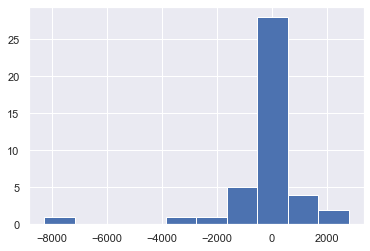

In [ ]:
plt.hist(AbsReturn1)

(array([28.,  7.,  4.,  0.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([-0.20489437,  0.05084973,  0.30659384,  0.56233794,  0.81808205,
         1.07382615,  1.32957026,  1.58531436,  1.84105847,  2.09680257,
         2.35254668]),
 <a list of 10 Patch objects>)

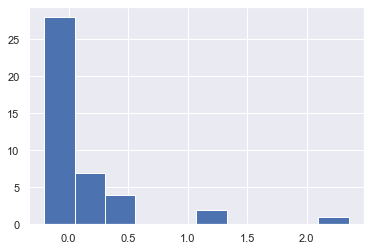

In [ ]:
plt.hist(PrcntReturn1)

# Consistency Check 2

In [ ]:
#@title Dataframe setup  { form-width: "30px" }
#the date in a nice date format
start_date_data2 = '2014-10-01' #@param {type:"date"}  
start2 = dt.datetime.strptime(start_date_data2, '%Y-%m-%d') 
stop2 = start 

#the symbols you gave me 
symbols = ['BTC-EUR','ETH-EUR', 'LTC-EUR' , 'XRP-EUR', 'BCH-EUR','MIOTA-EUR' ]

#create a dictionary with all the stocks Q: do you prefer to work with lists of dictionaries ? 
dict_of_stock2 = { s: web.DataReader(s, "yahoo", start2, stop2) for s in (symbols) }

In [ ]:
#@title SMA main: different rolling window sizes { form-width: "30px" }

#Only getting close since it is all we are using 
Close2=dict_of_stock2['BTC-EUR']['Close']
Close2=Close2.groupby(Close2.index).first() #removes the duplicate indexes

# made them from 2-6 , 7-11 just cause it is easier to see. made into strings cause im using them as col_names
SMA1 = list(map(str, range(2, 30))) #
SMA2 = list(map(str, range(31, 60)))

# # table = [ Close.rolling(s,min_periods=1).mean() for s in (np.arange(1,10))]
data2 = pd.DataFrame.from_dict({ s: Close2.rolling(int(s),min_periods=1).mean() for s in SMA1 + SMA2 }) 
data2.insert(0, 'Close', Close2)


#This creates a df for the buy and sell values based on the conditions
buy_sell_df2 = pd.DataFrame.from_dict({  sma1 + '_' + sma2: conditions_fun (data2, sma1, sma2 , choices= [data2['Close'], -data2['Close']])  for sma1, sma2  in product(SMA1, SMA2) })
buy_sell_df2.insert(0, 'Close', Close2)

# other solution, currently not using it. 
# buy_sell_df.where(buy_sell_df.gt(0).cummax(), 0, inplace=True) #https://stackoverflow.com/questions/62533032/pandas-replace-col-values-before-first-postive-with-0/62533267#62533267
 

#if last non-zero element is negative(buying), replace with 0
s2 = buy_sell_df2.iloc[::-1] #inverts the dataframe 
buy_sell_df2[s2.lt(0).cumsum().eq(1) & (~s.gt(0).cummax())] = 0

#if first non-zero elemnt is positive (selling), replace with 0
s2 = buy_sell_df2.iloc[::] #normal dataframe 
buy_sell_df2[s2.gt(0).cumsum().eq(1) & (~s.lt(0).cummax())] = 0


Profit2 = pd.DataFrame( { 'Position': buy_sell_df2.sum()[1:].index, 'Value': buy_sell_df2.sum()[1:]  } ) 
Profit2.index=pd.MultiIndex.from_tuples(Profit2.Position.str.split('_').apply(tuple))

In [ ]:
best_sma1_2, best_sma2_2 = list(map(int, Profit2['Value'].idxmax(axis=1))) 

print("Maximum Return was ", Profit2['Value'].max() )
print("best short SMA pair is: ",best_sma1_2, ' ', best_sma2_2)

Maximum Return was  -5882.911117553711
best short SMA pair is:  4   31


In [ ]:
#26/07/2020: Getting Trades
Trades2 = buy_sell_df2['4_32'][buy_sell_df1['4_32'].ne(0)]
AbsReturn2, PrcntReturn2 =  Get_Returns(Trades2)

In [ ]:
np.mean(AbsReturn2), np.mean(PrcntReturn2)

(-157.1173811412993, 0.13439543344709534)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2., 16.,  0.,  2.]),
 array([-8291.41235352, -7184.0357666 , -6076.65917969, -4969.28259277,
        -3861.90600586, -2754.52941895, -1647.15283203,  -539.77624512,
          567.6003418 ,  1674.97692871,  2782.35351562]),
 <a list of 10 Patch objects>)

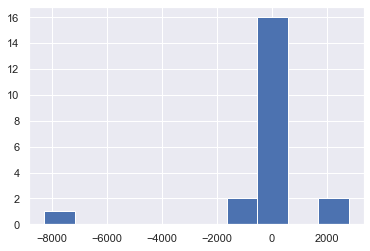

In [ ]:
plt.hist(AbsReturn2)

(array([12.,  3.,  4.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([-0.20489437,  0.05084973,  0.30659384,  0.56233794,  0.81808205,
         1.07382615,  1.32957026,  1.58531436,  1.84105847,  2.09680257,
         2.35254668]),
 <a list of 10 Patch objects>)

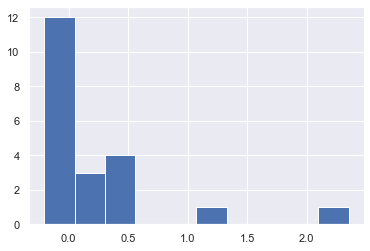

In [ ]:
plt.hist(PrcntReturn2)